In [1]:
# useful additional packages 
from qiskit import IBMQ, BasicAer, execute
from qiskit import Aer
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx



# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
# set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log
# ignoring deprecation errors on matplotlib
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

distance
 [[ 0. 57. 71. 80.]
 [57.  0. 41. 97.]
 [71. 41.  0. 68.]
 [80. 97. 68.  0.]]


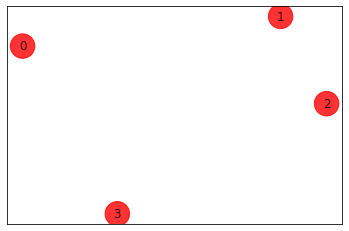

In [2]:
# Generating a graph of 4 nodes

n = 4
num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

order = (0, 1, 2, 3) Distance = 246.0
Best order from brute force = (0, 1, 2, 3) with total distance = 246.0


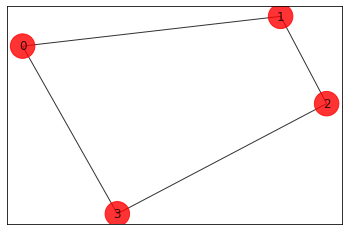

In [3]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
draw_tsp_solution(G, best_order, colors, pos)

In [4]:
qubitOp, offset = tsp.get_tsp_qubitops(ins)
algo_input = EnergyInput(qubitOp)

energy: -1600582.0
feasible: True
solution: [1, 2, 3, 0]
solution objective: 246.0


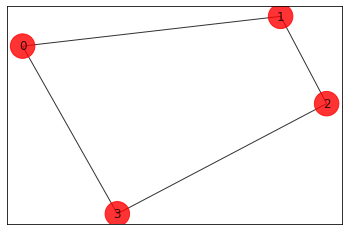

In [5]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
x = tsp.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
#print('tsp objective:', result['energy'] + offset)

print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

energy: -1455052.4180345936
time: 1401.0124862194061
feasible: True
solution: [3, 1, 0, 2]
solution objective: 293.0


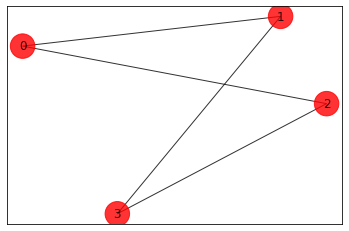

In [6]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)
"""
algorithm_cfg = {
    'name': 'VQE'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}
params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'provider': 'qiskit.Aer', 'name': 'statevector_simulator'}
}
result = run_algorithm(parahms,algo_input)
"""
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)